<a href="https://colab.research.google.com/github/prakash-bisht/Reinforcement-Learning/blob/main/Reinforcement_Learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Cliff Walking Environment.



The Cliff Walking environment is a gridworld with a discrete state space and discrete action space. The agent starts at grid cell S. The agent can move (deterministically) to the four neighboring cells by taking actions Up, Down, Left or Right. Trying to move out of the boundary results in staying in the same location. So, for example, trying to move left when at a cell on the leftmost column results in no movement at all and the agent remains in the same location. The agent receives -1 reward per step in most states, and -100 reward when falling off of the cliff. This is an episodic task; termination occurs when the agent reaches the goal grid cell G. Falling off of the cliff results in resetting to the start state, without termination.

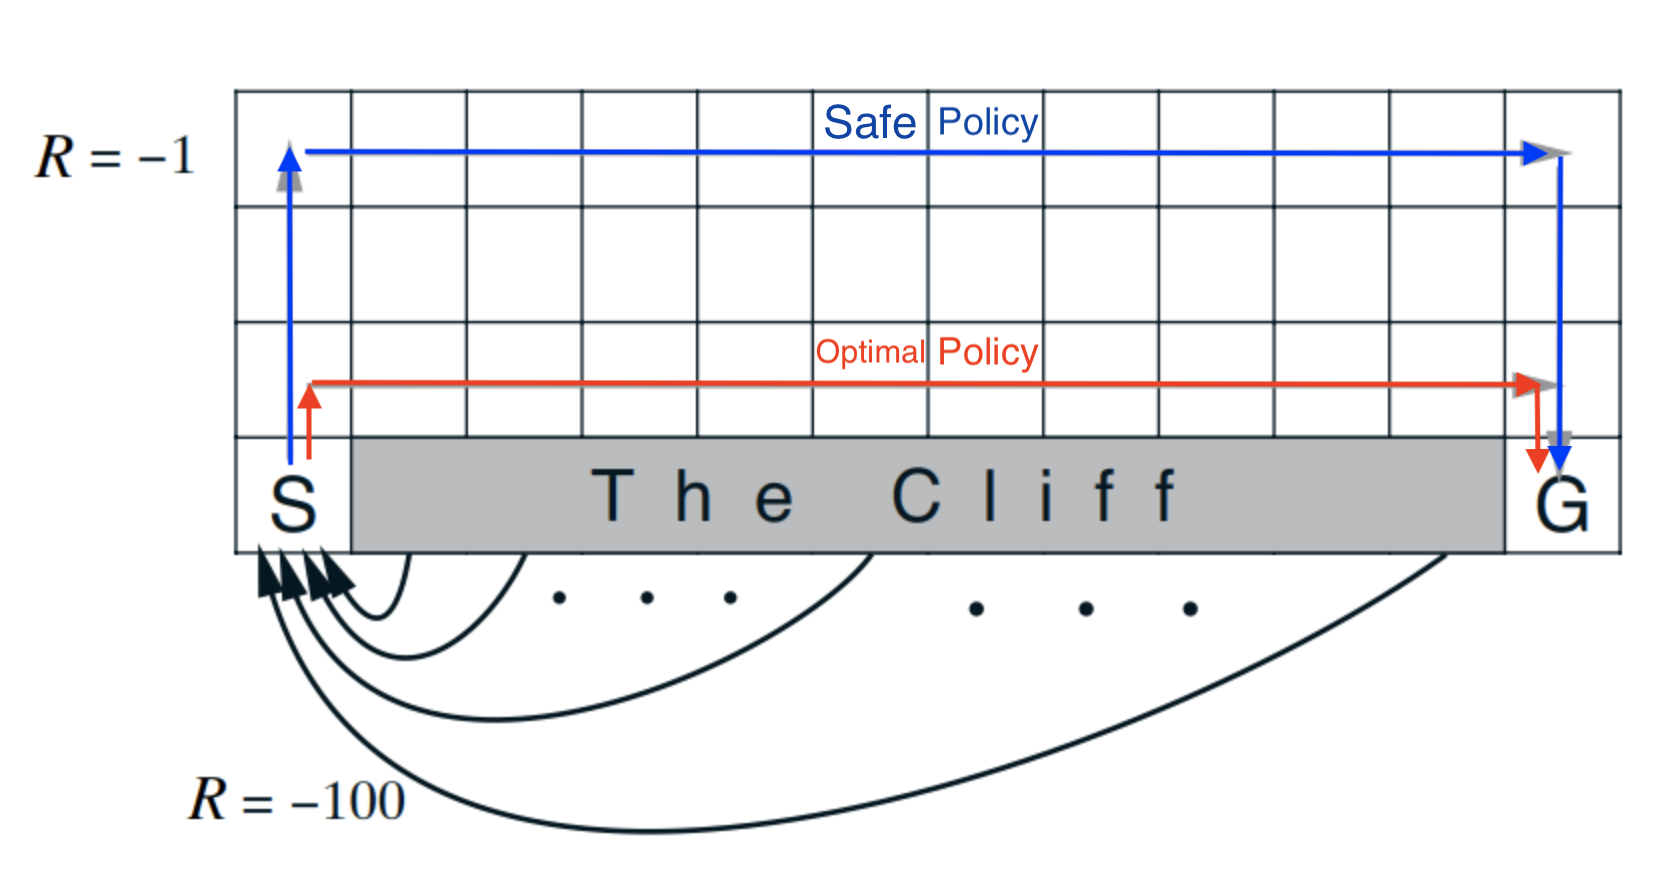

In [ ]:
!pip install jdc

In [3]:
import jdc
import numpy as np
from rl_glue import RLGlue
from Agent import BaseAgent
from Environment import BaseEnvironment
from manager import Manager
from itertools import product
from tqdm import tqdm

#Section 1. Environment

Converting 2-dimensional coordinates to a single index for the state,
One of the actions (action up), and,
Reward and termination.

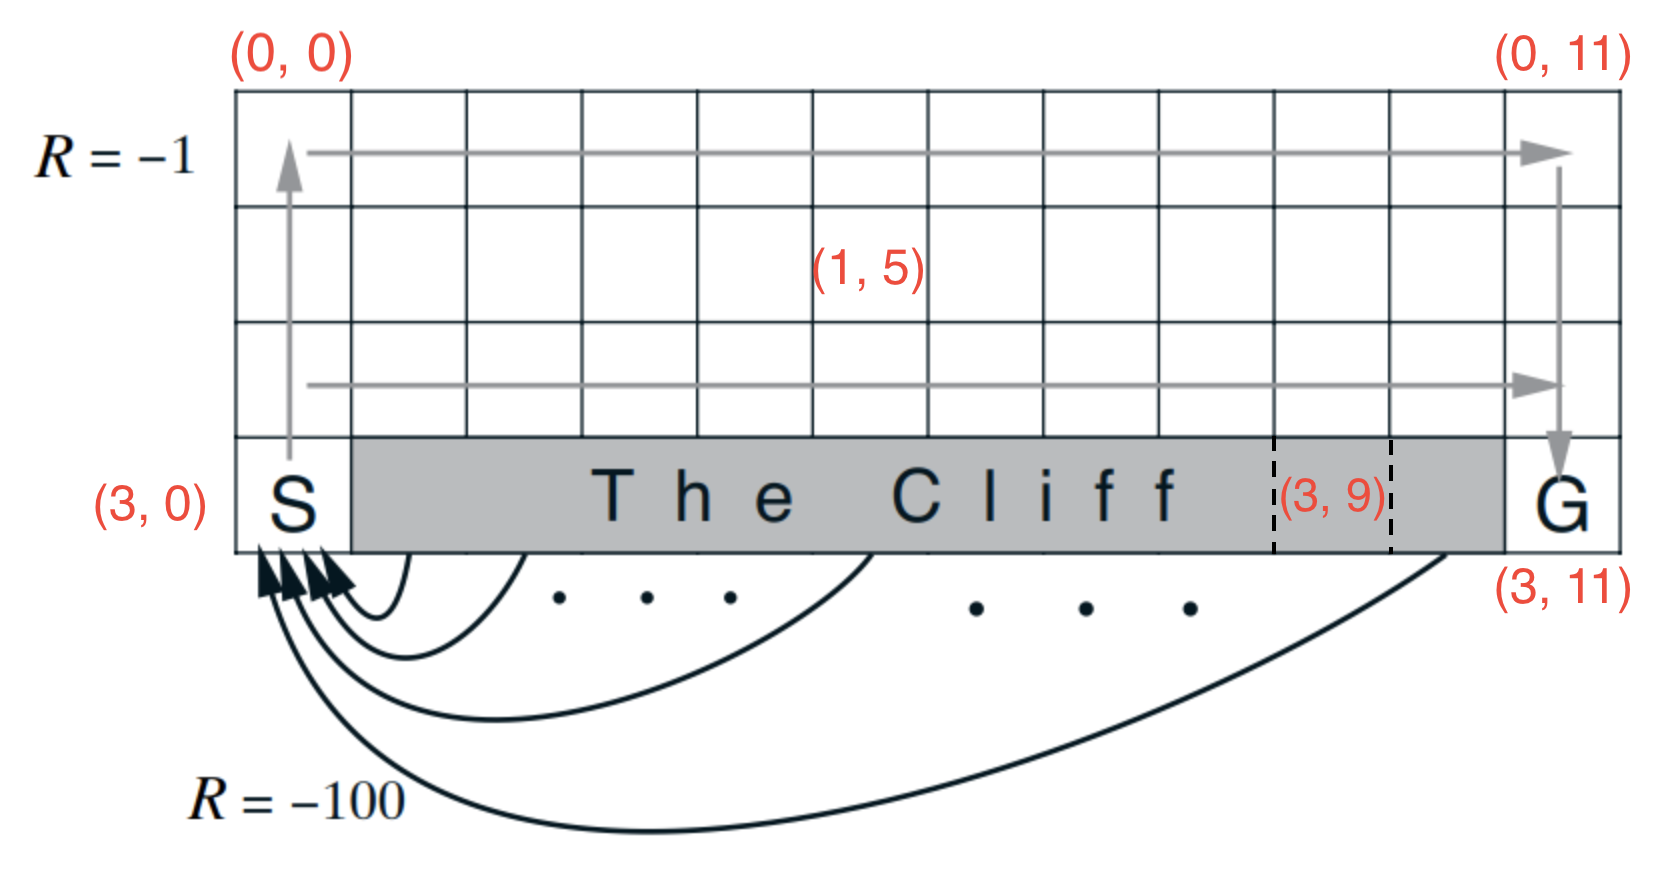

In [4]:
class CliffWalkEnvironment(BaseEnvironment):
    def env_init(self, agent_info={}):
        raise NotImplementedError

    def env_start(self, state):
        raise NotImplementedError

    def env_step(self, reward, state):
        raise NotImplementedError

    def env_end(self, reward):
        raise NotImplementedError

    def env_cleanup(self, reward):
        raise NotImplementedError

    # helper method
    def state(self, loc):
        raise NotImplementedError

env_init()

In [5]:
%%add_to CliffWalkEnvironment
def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state, boolean
            indicating if it's terminal.
        """

        reward = None
        state = None # See Aside
        termination = None
        self.reward_state_term = (reward, state, termination)

        # Set the default height to 4 and width to 12 (as in the diagram given above)
        self.grid_h = env_info.get("grid_height", 4)
        self.grid_w = env_info.get("grid_width", 12)

        # Starting location of agent is the bottom-left corner, (max x, min y).
        self.start_loc = (self.grid_h - 1, 0)
        # Goal location is the bottom-right corner. (max x, max y).
        self.goal_loc = (self.grid_h - 1, self.grid_w - 1)

        # The cliff will contain all the cells between the start_loc and goal_loc.
        self.cliff = [(self.grid_h - 1, i) for i in range(1, (self.grid_w - 1))]


Implement state()

The agent location can be described as a two-tuple or coordinate (x, y) describing the agent’s position. However, we can convert the (x, y) tuple into a single index and provide agents with just this integer. One reason for this choice is that the spatial aspect of the problem is secondary and there is no need for the agent to know about the exact dimensions of the environment. From the agent’s viewpoint, it is just perceiving some states, accessing their corresponding values in a table, and updating them. Both the coordinate (x, y) state representation and the converted coordinate representation are thus equivalent in this sense.

Given a grid cell location, the state() function should return the state; a single index corresponding to the location in the grid.


In [7]:
%%add_to CliffWalkEnvironment
def state(self, loc):
  i,j = loc
  return i * self.grid_w + j

env_start()

In env_start(), we initialize the agent location to be the start location and return the state corresponding to it as the first state for the agent to act upon. Additionally, we also set the reward and termination terms to be 0 and False respectively as they are consistent with the notion that there is no reward nor termination before the first action is even taken.

In [9]:
%%add_to CliffWalkEnvironment
def env_start(self):
    """The first method called when the episode starts, called before the
    agent starts.

    Returns:
        The first state from the environment.
    """
    reward = 0
    # agent_loc will hold the current location of the agent
    self.agent_loc = self.start_loc
    state = self.state(self.agent_loc)
    termination = False
    self.reward_state_term = (reward,state,termination)
    return self.reward_state_term[1]

Implement env_step()

Once an action is taken by the agent, the environment must provide a new state, reward and termination signal.

In the Cliff Walking environment, agents move around using a 4-cell neighborhood called the Von Neumann neighborhood (https://en.wikipedia.org/wiki/Von_Neumann_neighborhood). Thus, the agent has 4 available actions.

In [10]:
%%add_to CliffWalkEnvironment
def env_step(self, action):
    """A step taken by the environment.

    Args:
        action: The action taken by the agent

    Returns:
        (float, state, Boolean): a tuple of the reward, state,
            and boolean indicating if it's terminal.
    """

    if action == 0:
        ### START CODE HERE ###
        possible_next_loc = (self.agent_loc[0] - 1, self.agent_loc[1])
        if possible_next_loc[0] >= 0: # Within Bounds?
            self.agent_loc = possible_next_loc
        else:
            pass

    elif action == 1: # LEFT
        possible_next_loc = (self.agent_loc[0], self.agent_loc[1] - 1)
        if possible_next_loc[1] >= 0: # Within Bounds?
            self.agent_loc = possible_next_loc
        else:
            pass # Stay.
    elif action == 2: # DOWN
        possible_next_loc = (self.agent_loc[0] + 1, self.agent_loc[1])
        if possible_next_loc[0] < self.grid_h: # Within Bounds?
            self.agent_loc = possible_next_loc
        else:
            pass # Stay.
    elif action == 3: # RIGHT
        possible_next_loc = (self.agent_loc[0], self.agent_loc[1] + 1)
        if possible_next_loc[1] < self.grid_w: # Within Bounds?
            self.agent_loc = possible_next_loc
        else:
            pass # Stay.
    else:
        raise Exception(str(action) + " not in recognized actions [0: Up, 1: Left, 2: Down, 3: Right]!")

    reward = -1
    terminal = False

    if self.agent_loc == self.goal_loc: # Reached Goal!
        reward = -1
        terminal = True
    elif self.agent_loc in self.cliff: # Fell into the cliff!
        reward = -100
        terminal = False
        self.agent_loc = self.start_loc
    else:
        reward = -1
        terminal = False

    self.reward_state_term = (reward, self.state(self.agent_loc), terminal)
    return self.reward_state_term

env_cleanup()

There is not much cleanup to do for the Cliff Walking environment. Here, we simply reset the agent location to be the start location in this function.



In [14]:
%%add_to CliffWalkEnvironment
def env_cleanup(self):
    """Cleanup done after the environment ends"""
    self.agent_loc = self.start_loc

#Section 2. Agent

In [11]:
class TDAgent(BaseAgent):
    def agent_init(self, agent_info={}):
        raise NotImplementedError

    def agent_start(self, state):
        raise NotImplementedError

    def agent_step(self, reward, state):
        raise NotImplementedError

    def agent_end(self, reward):
        raise NotImplementedError

    def agent_cleanup(self):
        raise NotImplementedError

    def agent_message(self, message):
        raise NotImplementedError

agent_init()

As we did with the environment, we first initialize the agent once when a TDAgent object is created. In this function, we create a random number generator, seeded with the seed provided in the agent_info dictionary to get reproducible results. We also set the policy, discount and step size based on the agent_info dictionary. Finally, with a convention that the policy is always specified as a mapping from states to actions and so is an array of size (# States, # Actions), we initialize a values array of shape (# States,) to zeros.

In [12]:
%%add_to TDAgent
def agent_init(self, agent_info={}):
    """Setup for the agent called when the experiment first starts."""
    self.rand_generator = np.random.RandomState(agent_info.get("seed"))

    # Policy will be given, recall that the goal is to accurately estimate its corresponding value function.
    self.policy = agent_info.get("policy")
    self.discount = agent_info.get("discount")
    self.step_size = agent_info.get("step_size")
    self.values = np.zeros((self.policy.shape[0],))

agent_start()

In agent_start(), we choose an action based on the initial state and policy we are evaluating. We also cache the state so that we can later update its value when we perform a Temporal Difference update. Finally, we return the action chosen so that the RL loop can continue and the environment can execute this action.

In [13]:
%%add_to TDAgent
def agent_start(self, state):
    """The first method called when the episode starts, called after
    the environment starts.
    Args:
        state (Numpy array): the state from the environment's env_start function.
    Returns:
        The first action the agent takes.
    """
    # The policy can be represented as a (# States, # Actions) array. So, we can use
    # the second dimension here when choosing an action.
    action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
    self.last_state = state
    return action

Implement agent_step()

In agent_step(), the agent must:

Perform an update to improve the value estimate of the previously visited state, and
Act based on the state provided by the environment.
The latter of the two steps above has been implemented for you. Implement the former. Note that, unlike later in agent_end(), the episode has not yet ended in agent_step(). in other words, the previously observed state was not a terminal state.

In [15]:
%%add_to TDAgent
def agent_step(self, reward, state):
    """A step taken by the agent.
    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step after the last action, i.e., where the agent ended up after the
            last action
    Returns:
        The action the agent is taking.
    """
    # next state. We break this into two steps. Recall for example that the Monte-Carlo update
    # had the form: V[S_t] = V[S_t] + alpha * (target - V[S_t]), where the target was the return, G_t.
    target = reward + self.discount * self.values[state]
    self.values[self.last_state] = self.values[self.last_state] + self.step_size * (target - self.values[self.last_state])

    # Having updated the value for the last state, we now act based on the current
    # state, and set the last state to be current one as we will next be making an
    # update with it when agent_step is called next once the action we return from this function
    # is executed in the environment.

    action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
    self.last_state = state

    return action

Implement agent_end()

Implement the TD update for the case where an action leads to a terminal state.

In [16]:
%%add_to TDAgent
def agent_end(self, reward):
    """Run when the agent terminates.
    Args:
        reward (float): the reward the agent received for entering the terminal state.
    """
    target = reward
    self.values[self.last_state] = self.values[self.last_state] + self.step_size * (target - self.values[self.last_state])

agent_cleanup()

In cleanup, we simply reset the last state to be None to ensure that we are not storing any states past an episode.

In [17]:
%%add_to TDAgent
def agent_cleanup(self):
    """Cleanup done after the agent ends."""
    self.last_state = None

agent_message()

agent_message() can generally be used to get different kinds of information about an RLGlue agent in the interaction loop of RLGlue. Here, we conditonally check for a message matching "get_values" and use it to retrieve the values table the agent has been updating over time.

In [18]:
%%add_to TDAgent

def agent_message(self, message):
    """A function used to pass information from the agent to the experiment.
    Args:
        message: The message passed to the agent.
    Returns:
        The response (or answer) to the message.
    """
    if message == "get_values":
        return self.values
    else:
        raise Exception("TDAgent.agent_message(): Message not understood!")